<h2>Initializing</h2>
<p>Import Libraries, add variables for attribute strings (to save '') and load data</p>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from sklearn.metrics import classification_report
from scipy import interp
from sklearn.metrics import roc_curve, auc, accuracy_score 

fixed_acidity = 'fixed acidity'
volatile_acidity = 'volatile acidity'
citric_acid = 'citric acid'
residual_sugar = 'residual sugar'
chlorides = 'chlorides'
free_sulfur_dioxide = 'free sulfur dioxide'
total_sulfur_dioxide = 'total sulfur dioxide'
density = 'density'
ph = 'pH'
sulphates = 'sulphates'
alcohol = 'alcohol'
quality = 'quality'
qclass = 'qclass'
ratio_to_fixed = 'ratio_to_fixed'
ratio_to_volatile = 'ratio_to_volatile'
ph_acidity = 'ph_acidity'
ratio_to_ph = 'ratio_to_ph'

<p>Import red and white dataset.<br/>
Split into input matrix (independent vars) and output vector (target vars).<br/>
</p>

In [2]:
white = pd.read_csv("data/winequality-white1.csv")
red = pd.read_csv("data/winequality-red1.csv")
white_target = white[quality]
red_target = red[quality]
white_input = white.drop(quality,axis=1)
red_input = red.drop(quality,axis=1)


Add ratio of acidity to sugar as attribute.

In [3]:
white[ph_acidity] = 7 - white[ph]
red[ph_acidity] = 7 - red[ph]
white_input[ratio_to_fixed]=white[residual_sugar]/white[fixed_acidity]
white_input[ratio_to_volatile]=white[residual_sugar]/white[volatile_acidity]
white_input[ratio_to_ph]=white[residual_sugar]/white[ph_acidity]
red_input[ratio_to_fixed]=red[residual_sugar]/red[fixed_acidity]
red_input[ratio_to_volatile]=red[residual_sugar]/red[volatile_acidity]
red_input[ratio_to_ph]=red[residual_sugar]/red[ph_acidity]

<p>Normalize using MinMax Normalizer.</p>

In [4]:
white_norm=(white_input-white_input.min())/(white_input.max()-white_input.min())
red_norm=(red_input-red_input.min())/(red_input.max()-red_input.min())

<p>Correlation Matrices</p>

In [5]:
wcorr = white.corr()
wcorr.style.background_gradient().set_precision(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,ph_acidity
fixed acidity,1,-0.0227,0.289,0.089,0.0231,-0.0494,0.0911,0.265,-0.426,-0.0171,-0.121,-0.114,0.426
volatile acidity,-0.0227,1,-0.149,0.0643,0.0705,-0.097,0.0893,0.0271,-0.0319,-0.0357,0.0677,-0.195,0.0319
citric acid,0.289,-0.149,1,0.0942,0.114,0.0941,0.121,0.15,-0.164,0.0623,-0.0757,-0.00921,0.164
residual sugar,0.089,0.0643,0.0942,1,0.0887,0.299,0.401,0.839,-0.194,-0.0267,-0.451,-0.0976,0.194
chlorides,0.0231,0.0705,0.114,0.0887,1,0.101,0.199,0.257,-0.0904,0.0168,-0.36,-0.21,0.0904
free sulfur dioxide,-0.0494,-0.097,0.0941,0.299,0.101,1,0.616,0.294,-0.000618,0.0592,-0.25,0.00816,0.000618
total sulfur dioxide,0.0911,0.0893,0.121,0.401,0.199,0.616,1,0.53,0.00232,0.135,-0.449,-0.175,-0.00232
density,0.265,0.0271,0.15,0.839,0.257,0.294,0.53,1,-0.0936,0.0745,-0.78,-0.307,0.0936
pH,-0.426,-0.0319,-0.164,-0.194,-0.0904,-0.000618,0.00232,-0.0936,1,0.156,0.121,0.0994,-1
sulphates,-0.0171,-0.0357,0.0623,-0.0267,0.0168,0.0592,0.135,0.0745,0.156,1,-0.0174,0.0537,-0.156


In [6]:
rcorr = red.corr()
rcorr.style.background_gradient().set_precision(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,ph_acidity
fixed acidity,1,-0.256,0.672,0.115,0.0937,-0.154,-0.113,0.668,-0.683,0.183,-0.0617,0.124,0.683
volatile acidity,-0.256,1,-0.552,0.00192,0.0613,-0.0105,0.0765,0.022,0.235,-0.261,-0.202,-0.391,-0.235
citric acid,0.672,-0.552,1,0.144,0.204,-0.061,0.0355,0.365,-0.542,0.313,0.11,0.226,0.542
residual sugar,0.115,0.00192,0.144,1,0.0556,0.187,0.203,0.355,-0.0857,0.00553,0.0421,0.0137,0.0857
chlorides,0.0937,0.0613,0.204,0.0556,1,0.00556,0.0474,0.201,-0.265,0.371,-0.221,-0.129,0.265
free sulfur dioxide,-0.154,-0.0105,-0.061,0.187,0.00556,1,0.668,-0.0219,0.0704,0.0517,-0.0694,-0.0507,-0.0704
total sulfur dioxide,-0.113,0.0765,0.0355,0.203,0.0474,0.668,1,0.0713,-0.0665,0.0429,-0.206,-0.185,0.0665
density,0.668,0.022,0.365,0.355,0.201,-0.0219,0.0713,1,-0.342,0.149,-0.496,-0.175,0.342
pH,-0.683,0.235,-0.542,-0.0857,-0.265,0.0704,-0.0665,-0.342,1,-0.197,0.206,-0.0577,-1
sulphates,0.183,-0.261,0.313,0.00553,0.371,0.0517,0.0429,0.149,-0.197,1,0.0936,0.251,0.197


<h2>Assigning classes</h2>
<p>
    Assign classes based on quality. Less than 6; 6; better than 6. Because it makes sense considering the distribution of ratings.
</p>

In [7]:
conditions = [(white['quality'] < 6),
              (white['quality'] > 6)]
choices = ['1_low', '3_high']
white['class'] = np.select(conditions, choices, default = '2_medium')

conditions = [(red['quality'] < 6),
              (red['quality'] > 6)]
red['class'] = np.select(conditions, choices, default = '2_medium')

print('class distribution fot white:')
print(white['class'].value_counts())
print('\n class distribution for red:')
print(red['class'].value_counts())

white_norm['class']=white['class']
red_norm['class']=red['class']
white_targetclass = white['class']
red_targetclass = red['class']

class distribution fot white:
2_medium    2198
1_low       1640
3_high      1060
Name: class, dtype: int64

 class distribution for red:
1_low       744
2_medium    638
3_high      217
Name: class, dtype: int64


In [8]:
white_norm_input = white_norm.drop('class', axis = 1)
red_norm_input = red_norm.drop('class', axis = 1)

In [9]:
#white_norm.loc[white_norm['class']=='3_high'].describe()
#white_norm.loc[white_norm['class']=='2_medium'].describe()
#white_norm.loc[white_norm['class']=='1_low'].describe()
white_norm_filtered = white_norm_input.drop([residual_sugar,chlorides,ph,sulphates],axis=1)
white_norm_filtered.describe()

,fixed acidity,volatile acidity,citric acid,free sulfur dioxide,total sulfur dioxide,density,alcohol,ratio_to_fixed,ratio_to_volatile,ratio_to_ph
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,0.293730,0.194354,0.201320,0.116056,0.300141,0.133360,0.405527,0.103613,0.181037,0.083874
std,0.081141,0.098818,0.072903,0.059258,0.098603,0.057662,0.198487,0.088181,0.163832,0.072811
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.240385,0.127451,0.162651,0.073171,0.229698,0.088924,0.241935,0.022366,0.049498,0.016763
50%,0.288462,0.176471,0.192771,0.111498,0.290023,0.127820,0.387097,0.086339,0.127643,0.067616
75%,0.336538,0.235294,0.234940,0.153310,0.366589,0.173318,0.548387,0.159599,0.263530,0.133723
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
#red_norm.loc[red_norm['class']=='3_high'].describe()
#red_norm.loc[red_norm['class']=='2_medium'].describe()
#red_norm.loc[red_norm['class']=='1_low'].describe()
red_norm_filtered = red_norm_input.drop([residual_sugar,chlorides,ph,sulphates],axis=1)
red_norm_filtered.describe()

,fixed acidity,volatile acidity,citric acid,free sulfur dioxide,total sulfur dioxide,density,alcohol,ratio_to_fixed,ratio_to_volatile,ratio_to_ph
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,0.329171,0.279329,0.270976,0.209506,0.142996,0.490211,0.311228,0.085049,0.076716,0.123027
std,0.154079,0.122644,0.194801,0.147326,0.116238,0.138571,0.163949,0.077655,0.072294,0.098737
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.221239,0.184932,0.090000,0.084507,0.056537,0.406021,0.169231,0.050258,0.038003,0.078053
50%,0.292035,0.273973,0.260000,0.183099,0.113074,0.490455,0.276923,0.067617,0.058549,0.098049
75%,0.407080,0.356164,0.420000,0.281690,0.197880,0.570117,0.415385,0.092156,0.092474,0.128207
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<h2>k-NN classification<h2><p>https://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html#the-curse-of-dimensionality</p>

<h3>white: normalized and selected for attributes with low std/range</h3>

1 neighbours:
             precision    recall  f1-score   support

      1_low       0.74      0.68      0.71       164
   2_medium       0.69      0.69      0.69       220
     3_high       0.64      0.74      0.69       106

avg / total       0.70      0.70      0.70       490

             precision    recall  f1-score   support

      1_low       0.74      0.75      0.75       164
   2_medium       0.74      0.77      0.75       220
     3_high       0.71      0.64      0.67       106

avg / total       0.73      0.73      0.73       490

             precision    recall  f1-score   support

      1_low       0.67      0.65      0.66       164
   2_medium       0.65      0.65      0.65       220
     3_high       0.64      0.68      0.66       106

avg / total       0.66      0.66      0.66       490

             precision    recall  f1-score   support

      1_low       0.71      0.72      0.72       164
   2_medium       0.69      0.67      0.68       220
     3_high       0.64

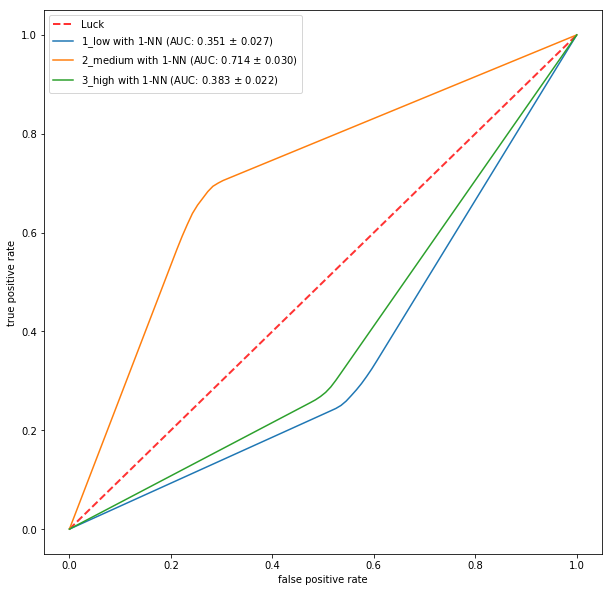

In [11]:
#define function for computing average roc for cross validation
#see http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
def avg_roc(cv, estimator, data, target, pos_label):
    mean_fpr = np.linspace(0, 1, 100) # = [0.0, 0.01, 0.02, 0.03, ... , 0.99, 1.0]
    tprs = []
    aucs = []
    
    for train_indices, test_indices in cv.split(data, target):
        train_data = data[train_indices]
        train_target = target[train_indices]
        estimator.fit(train_data, train_target)

        test_data = data[test_indices]
        test_target = target[test_indices]
        decision_for_each_class = estimator.predict_proba(test_data) 
        print(classification_report(test_target, estimator.predict(test_data)))
        
        fpr, tpr, thresholds = roc_curve(test_target, decision_for_each_class[:,1], pos_label=pos_label)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0 # tprs[-1] access the last element
        aucs.append(auc(fpr, tpr))
        
        #plt.plot(fpr, tpr)# plot for each fold
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0 # set the last tpr to 1
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    return mean_fpr, mean_tpr, mean_auc, std_auc
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#cv = KFold(n_splits=3)
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8) # draw diagonal
inputs = white_norm_filtered.values
targets = white_targetclass
for n_neighbour in range(1,2):
    print(str(n_neighbour) + " neighbours:")
    knn_estimator_white_norm_select = KNeighborsClassifier(n_neighbour)
    for classlabel in ['1_low','2_medium','3_high']:
        mean_fpr, mean_tpr, mean_auc, std_auc = avg_roc(cv, knn_estimator_white_norm_select, inputs, targets,classlabel)
        plt.plot(mean_fpr, mean_tpr, label='{} with {}-NN (AUC: {:.3f} $\pm$ {:.3f})'.format(classlabel,n_neighbour, mean_auc, std_auc))
        print(str(n_neighbour)+ " neighbours//")
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()
plt.show() 

<h3><i>red: </i>normalized and selected for attributes with low std/range</h3>

1 neighbours:
             precision    recall  f1-score   support

      1_low       0.72      0.72      0.72        75
   2_medium       0.64      0.64      0.64        64
     3_high       0.73      0.73      0.73        22

avg / total       0.69      0.69      0.69       161

             precision    recall  f1-score   support

      1_low       0.75      0.81      0.78        75
   2_medium       0.70      0.58      0.63        64
     3_high       0.63      0.77      0.69        22

avg / total       0.71      0.71      0.71       161

             precision    recall  f1-score   support

      1_low       0.77      0.73      0.75        75
   2_medium       0.65      0.64      0.65        64
     3_high       0.59      0.73      0.65        22

avg / total       0.70      0.70      0.70       161

             precision    recall  f1-score   support

      1_low       0.79      0.75      0.77        75
   2_medium       0.67      0.72      0.69        64
     3_high       0.57

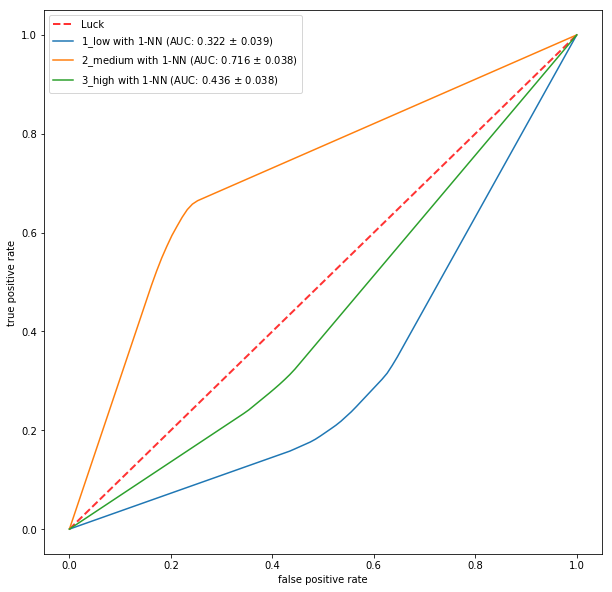

In [12]:
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8) # draw diagonal
inputs = red_norm_filtered.values
targets = red_targetclass
for n_neighbour in range(1,2):
    print(str(n_neighbour) + " neighbours:")
    knn_estimator_red_norm_select = KNeighborsClassifier(n_neighbour)
    for classlabel in ['1_low','2_medium','3_high']:
        mean_fpr, mean_tpr, mean_auc, std_auc = avg_roc(cv, knn_estimator_red_norm_select, inputs, targets,classlabel)
        plt.plot(mean_fpr, mean_tpr, label='{} with {}-NN (AUC: {:.3f} $\pm$ {:.3f})'.format(classlabel,n_neighbour, mean_auc, std_auc))
        print(str(n_neighbour)+ " neighbours//")
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()
plt.show() 

<h3>white: normalized unselected</h3>

1 neighbours:
             precision    recall  f1-score   support

      1_low       0.74      0.70      0.72       164
   2_medium       0.69      0.69      0.69       220
     3_high       0.64      0.68      0.66       106

avg / total       0.69      0.69      0.69       490

             precision    recall  f1-score   support

      1_low       0.74      0.66      0.70       164
   2_medium       0.70      0.76      0.73       220
     3_high       0.67      0.64      0.65       106

avg / total       0.70      0.70      0.70       490

             precision    recall  f1-score   support

      1_low       0.75      0.65      0.70       164
   2_medium       0.67      0.73      0.70       220
     3_high       0.64      0.64      0.64       106

avg / total       0.69      0.69      0.69       490

             precision    recall  f1-score   support

      1_low       0.72      0.73      0.73       164
   2_medium       0.70      0.69      0.70       220
     3_high       0.67

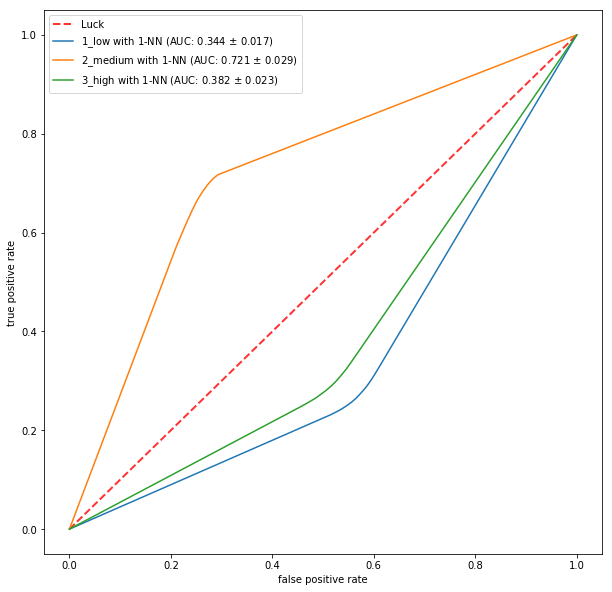

In [13]:
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8) # draw diagonal
inputs = white_norm_input.values
targets = white_targetclass
for n_neighbour in range(1,2):
    print(str(n_neighbour) + " neighbours:")
    knn_estimator_white_norm = KNeighborsClassifier(n_neighbour)
    for classlabel in ['1_low','2_medium','3_high']:
        mean_fpr, mean_tpr, mean_auc, std_auc = avg_roc(cv, knn_estimator_white_norm, inputs , targets,classlabel)
        plt.plot(mean_fpr, mean_tpr, label='{} with {}-NN (AUC: {:.3f} $\pm$ {:.3f})'.format(classlabel,n_neighbour, mean_auc, std_auc))
        print(str(n_neighbour)+ " neighbours//")
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()
plt.show()

<h3><i>red: </i> normalized unselected</h3>

1 neighbours:
             precision    recall  f1-score   support

      1_low       0.75      0.71      0.73        75
   2_medium       0.65      0.66      0.65        64
     3_high       0.60      0.68      0.64        22

avg / total       0.69      0.68      0.68       161

             precision    recall  f1-score   support

      1_low       0.72      0.79      0.75        75
   2_medium       0.66      0.58      0.62        64
     3_high       0.70      0.73      0.71        22

avg / total       0.69      0.70      0.69       161

             precision    recall  f1-score   support

      1_low       0.77      0.77      0.77        75
   2_medium       0.67      0.62      0.65        64
     3_high       0.62      0.73      0.67        22

avg / total       0.71      0.71      0.71       161

             precision    recall  f1-score   support

      1_low       0.81      0.77      0.79        75
   2_medium       0.70      0.73      0.72        64
     3_high       0.55

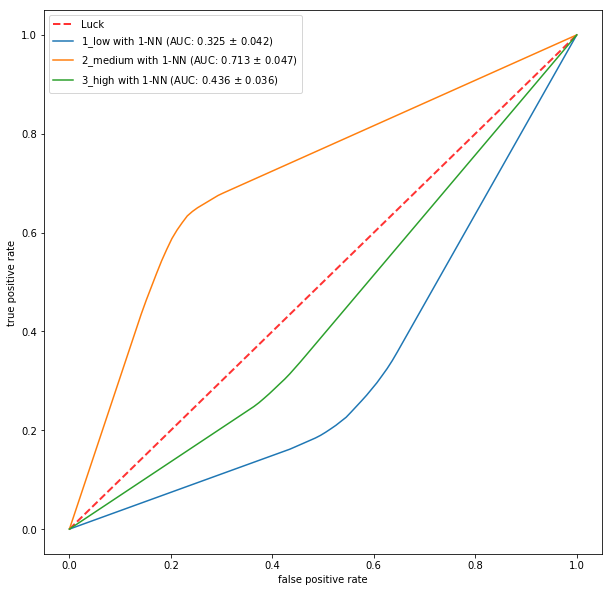

In [14]:
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8) # draw diagonal
inputs = red_norm_input.values
targets = red_targetclass
for n_neighbour in range(1,2):
    print(str(n_neighbour) + " neighbours:")
    knn_estimator_red_norm = KNeighborsClassifier(n_neighbour)
    for classlabel in ['1_low','2_medium','3_high']:
        mean_fpr, mean_tpr, mean_auc, std_auc = avg_roc(cv, knn_estimator_red_norm, inputs , targets,classlabel)
        plt.plot(mean_fpr, mean_tpr, label='{} with {}-NN (AUC: {:.3f} $\pm$ {:.3f})'.format(classlabel,n_neighbour, mean_auc, std_auc))
        print(str(n_neighbour)+ " neighbours//")
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()
plt.show()

<h3> white: unfiltered, unnormalized <h3>

1 neighbours:
             precision    recall  f1-score   support

      1_low       0.66      0.63      0.64       164
   2_medium       0.70      0.69      0.69       220
     3_high       0.58      0.63      0.61       106

avg / total       0.66      0.66      0.66       490

             precision    recall  f1-score   support

      1_low       0.70      0.65      0.67       164
   2_medium       0.70      0.74      0.72       220
     3_high       0.65      0.65      0.65       106

avg / total       0.69      0.69      0.69       490

             precision    recall  f1-score   support

      1_low       0.62      0.57      0.59       164
   2_medium       0.64      0.65      0.64       220
     3_high       0.53      0.59      0.56       106

avg / total       0.61      0.61      0.61       490

             precision    recall  f1-score   support

      1_low       0.63      0.62      0.62       164
   2_medium       0.62      0.64      0.63       220
     3_high       0.58

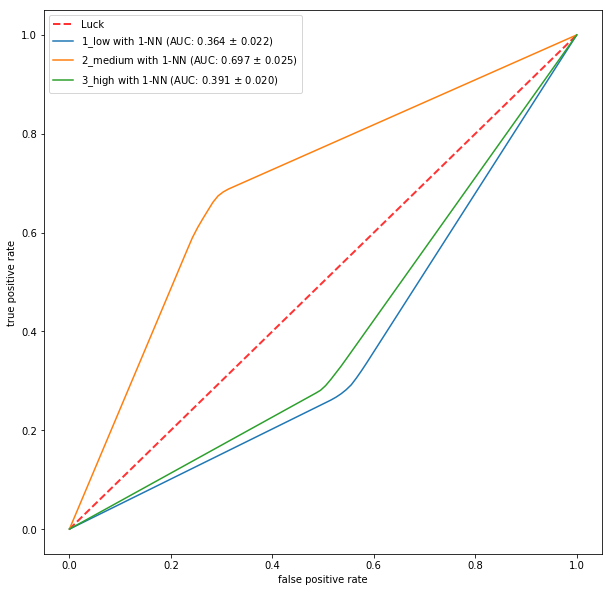

In [15]:
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8) # draw diagonal
inputs = white_input.values
targets = white_targetclass
for n_neighbour in range(1,2):
    print(str(n_neighbour) + " neighbours:")
    knn_estimator_white = KNeighborsClassifier(n_neighbour)
    for classlabel in ['1_low','2_medium','3_high']:
        mean_fpr, mean_tpr, mean_auc, std_auc = avg_roc(cv, knn_estimator_white, inputs , targets,classlabel)
        plt.plot(mean_fpr, mean_tpr, label='{} with {}-NN (AUC: {:.3f} $\pm$ {:.3f})'.format(classlabel,n_neighbour, mean_auc, std_auc))
        print(str(n_neighbour)+ " neighbours//")
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()
plt.show()

<h3>red, unnormalized, unselected</h3>

1 neighbours:
             precision    recall  f1-score   support

      1_low       0.66      0.72      0.69        75
   2_medium       0.58      0.53      0.55        64
     3_high       0.60      0.55      0.57        22

avg / total       0.62      0.62      0.62       161

             precision    recall  f1-score   support

      1_low       0.70      0.71      0.70        75
   2_medium       0.60      0.58      0.59        64
     3_high       0.48      0.50      0.49        22

avg / total       0.63      0.63      0.63       161

             precision    recall  f1-score   support

      1_low       0.68      0.72      0.70        75
   2_medium       0.65      0.55      0.59        64
     3_high       0.64      0.82      0.72        22

avg / total       0.66      0.66      0.66       161

             precision    recall  f1-score   support

      1_low       0.71      0.72      0.72        75
   2_medium       0.59      0.56      0.58        64
     3_high       0.42

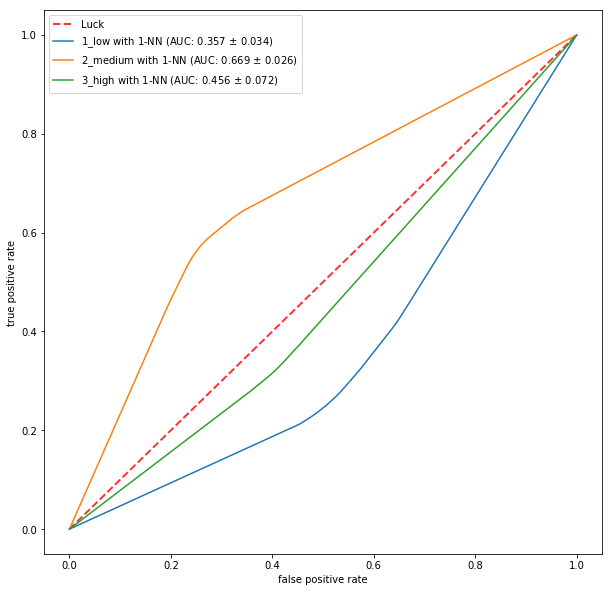

In [16]:
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8) # draw diagonal
inputs = red_input.values
targets = red_targetclass
for n_neighbour in range(1,2):
    print(str(n_neighbour) + " neighbours:")
    knn_estimator_red = KNeighborsClassifier(n_neighbour)
    for classlabel in ['1_low','2_medium','3_high']:
        mean_fpr, mean_tpr, mean_auc, std_auc = avg_roc(cv, knn_estimator_red, inputs , targets,classlabel)
        plt.plot(mean_fpr, mean_tpr, label='{} with {}-NN (AUC: {:.3f} $\pm$ {:.3f})'.format(classlabel,n_neighbour, mean_auc, std_auc))
        print(str(n_neighbour)+ " neighbours//")
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()
plt.show()